In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from statsmodels.tsa.stattools import adfuller, pacf, acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.arima_model import ARIMA
from statistics import Arima
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from IPython.core.display import display

plt.rcParams["figure.figsize"] = (15,8)
plt.rcParams["axes.labelsize"] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['grid.linewidth'] = .5
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['figure.titlesize'] = 20

In [2]:
df = pd.read_csv('./data/RTSI-dailyhistory-ru.csv', parse_dates=['Date'], index_col='Date', dayfirst=True)
series = df[('2009-01' < df.index) & (df.index < '2020-02')].Close
series = series.resample('1m').last()

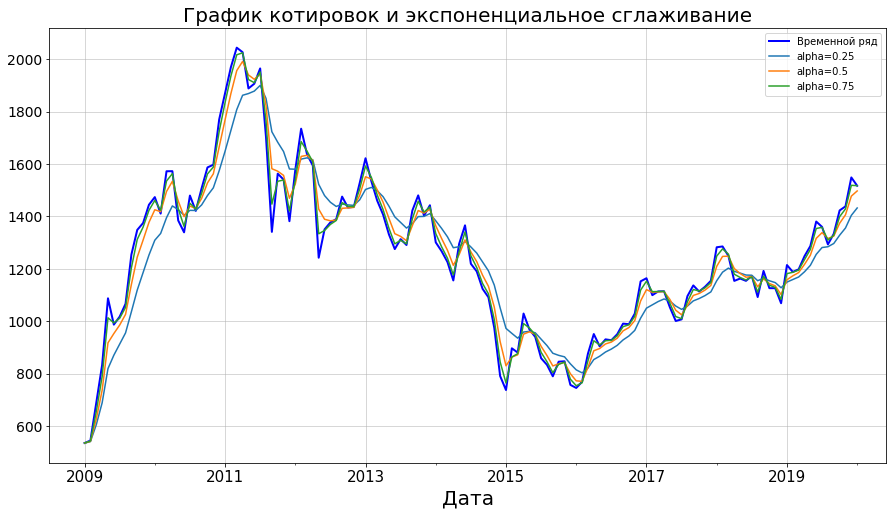

In [3]:
ax = series.plot(legend=True, color='blue', label='Временной ряд', linewidth=2)
for alpha in [.25, .5, .75]:
    series.ewm(alpha=alpha).mean().plot(ax=ax, label=f'alpha={alpha}', legend=True)
ax.set_title('График котировок и экспоненциальное сглаживание')
ax.set_xlabel('Дата');
ax.set_xlim('2008-07', '2020-06')
del ax

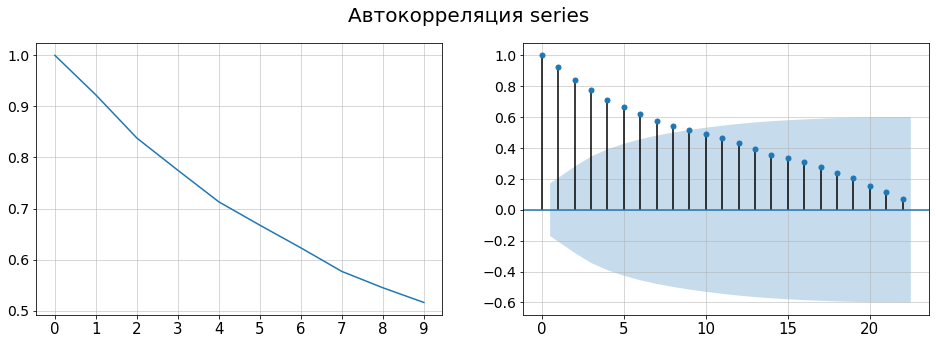

In [4]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
fig.suptitle('Автокорреляция series')

ax1.set_xticks(np.linspace(0, 10, 11))
ax1.plot(acf(series, fft=False)[:10])

plot_acf(series, ax=ax2, title='');

plt.show();
del fig, ax1, ax2

### Тест Фуллера на стационарность ряда

In [5]:
fuller_test = adfuller(series)
if fuller_test[0] > fuller_test[4]['5%']:
    print('Ряд нестационарен')
else:
    print('Ряд стационарен')
del fuller_test

Ряд нестационарен


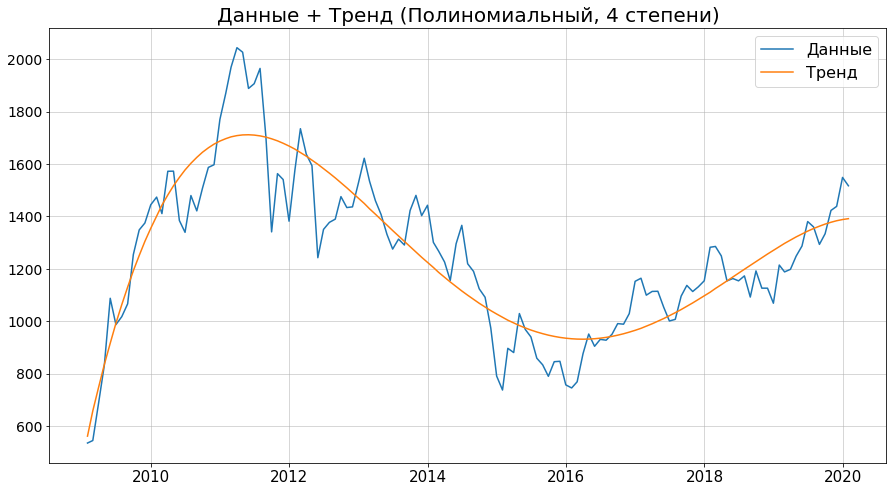

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     138.2
Date:                Sun, 15 Mar 2020   Prob (F-statistic):           1.86e-45
Time:                        06:36:49   Log-Likelihood:                -837.17
No. Observations:                 133   AIC:                             1684.
Df Residuals:                     128   BIC:                             1699.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        561.3528     55.398     10.133      0.000     451.739     670.967
x1            99.1642      5.862     16.917      0.000      87.565     110.763
x2            -2.7296      0.182    -15.033      0.000      -3.089      -2.370
x3             0.0256      0.002     12.353      0.000       0.021       0.030
x4          -7.75e-05   7.78e-06     -9.961      0.000   -9.29e-05   -6.21e-05
==============================================================================
Omnibus:                        0.478   Durbin-Watson:                   0.527
Prob(Omnibus):                  0.787   Jarque-Bera (JB):                0.247
Skew:                          -0.095   Prob(JB):                        0.884
Kurtosis:                       3.092   Cond. No.                     4.92e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.92e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [6]:
pf = PolynomialFeatures(degree=4)
xp = pf.fit_transform(np.arange(series.size)[:, np.newaxis])
fitted_model = sm.OLS(series, xp).fit()

plt.title('Данные + Тренд (Полиномиальный, 4 степени)')
plt.plot(series, label='Данные')

# Значения линии тренда
# Вместо .fittedvalues можео .predict(xp)
series_trend = fitted_model.fittedvalues
series_remains = fitted_model.resid

plt.plot(series_trend, label='Тренд');
plt.legend(fontsize=16)
plt.show()
display(fitted_model.summary())

del pf, xp, fitted_model

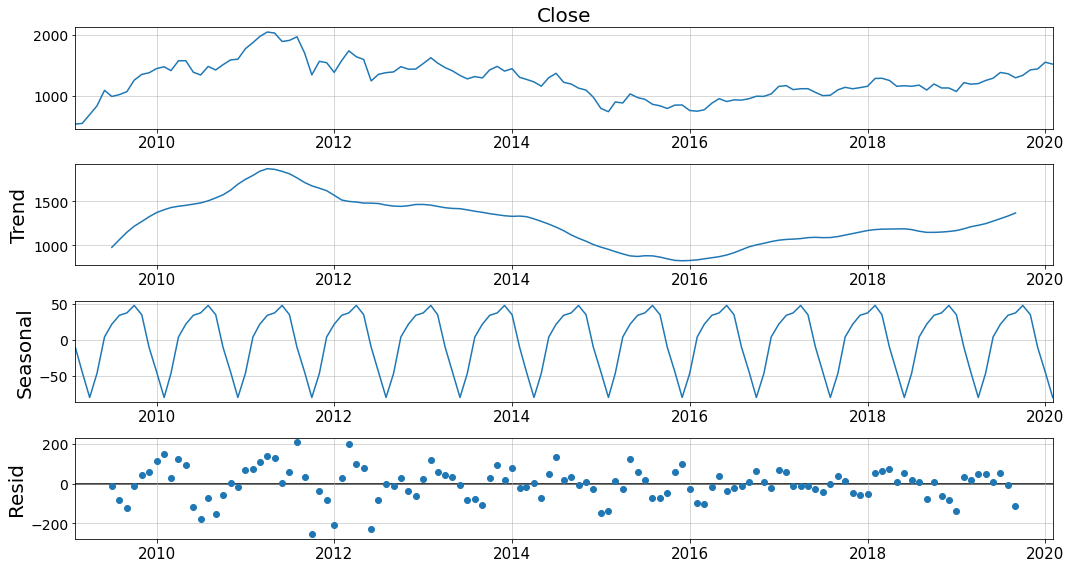

In [7]:
sm.tsa.seasonal_decompose(series.interpolate(), period=10).plot();

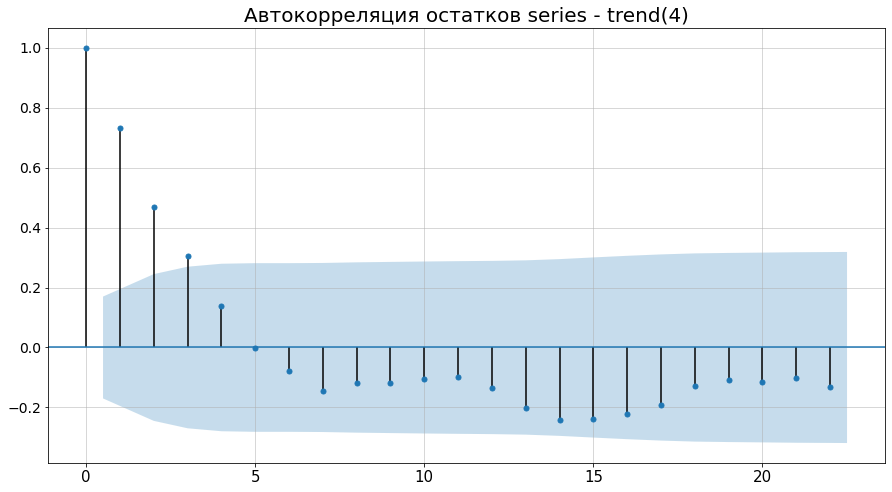

In [8]:
plot_acf(series_remains, title='Автокорреляция остатков series - trend(4)');

In [9]:
# Лучшие pdq - 4, 0, 4
model = ARIMA(series_remains, order=(4, 0, 4))
arima_by_series_remains = model.fit()
display(arima_by_series_remains.summary())

del model

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  133
Model:                     ARMA(4, 4)   Log Likelihood                -774.466
Method:                       css-mle   S.D. of innovations             79.336
Date:                Sun, 15 Mar 2020   AIC                           1568.932
Time:                        06:36:51   BIC                           1597.835
Sample:                    01-31-2009   HQIC                          1580.677
                         - 01-31-2020                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4286      3.122      0.137      0.891      -5.691       6.548
ar.L1.y        0.2242      0.109      2.054      0.040       0.010       0.438
ar.L2.y        0.9350      0.068     13.823      0.000       0.802       1.068
ar.L3.y        0.3193      0.091      3.510      0.000       0.141       0.498
ar.L4.y       -0.6568      0.072     -9.097      0.000      -0.798      -0.515
ma.L1.y        0.5956      0.152      3.926      0.000       0.298       0.893
ma.L2.y       -0.7338      0.108     -6.787      0.000      -0.946      -0.522
ma.L3.y       -0.9442      0.111     -8.475      0.000      -1.163      -0.726
ma.L4.y        0.0824      0.148      0.558      0.577      -0.207       0.372
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.8727           -0.6394j            1.0819           -0.3994
AR.2           -0.8727           +0.6394j            1.0819            0.3994
AR.3            1.1158           -0.2365j            1.1406           -0.0332
AR.4            1.1158           +0.2365j            1.1406            0.0332
MA.1            1.0000           -0.0000j            1.0000           -0.0000
MA.2           -0.8390           -0.5442j            1.0000           -0.4084
MA.3           -0.8390           +0.5442j            1.0000            0.4084
MA.4           12.1423           -0.0000j           12.1423           -0.0000
-----------------------------------------------------------------------------
"""

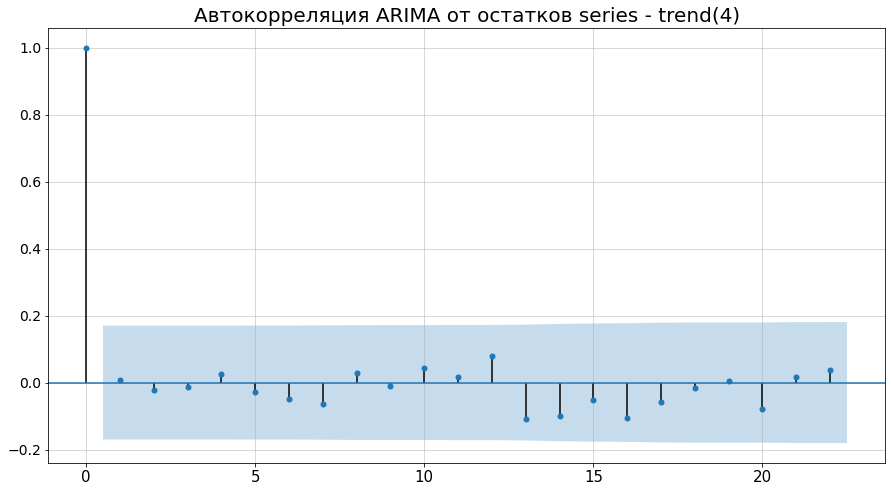

In [10]:
plot_acf(arima_by_series_remains.resid, title='Автокорреляция ARIMA от остатков series - trend(4)');

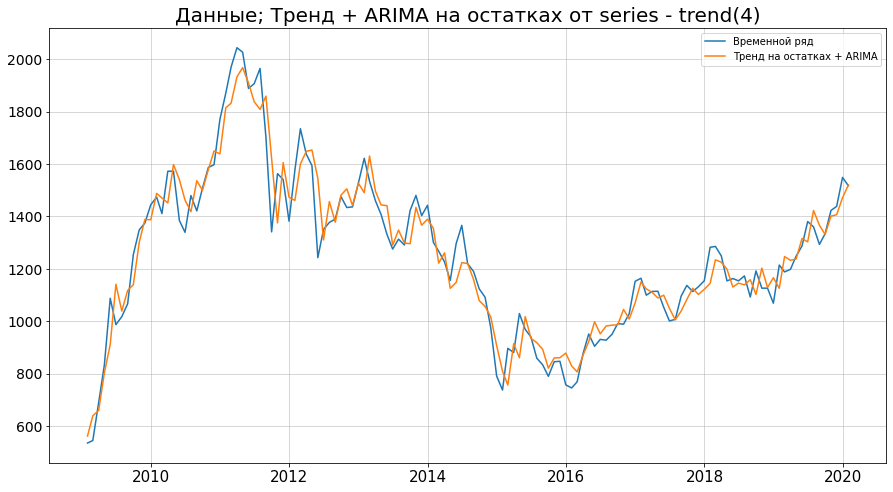

In [11]:
plt.plot(series, label='Временной ряд');
plt.plot(series_trend + arima_by_series_remains.fittedvalues, label='Тренд на остатках + ARIMA');
plt.title('Данные; Тренд + ARIMA на остатках от series - trend(4)')
plt.legend()
plt.show()